# B. Exploratory Data Analysis

# 1. Content

# 2. Introduction 

## 2.1 Questions to answer 

- Is location a key consideration for rent?
- Does quantity supplied affect the price of rent?
- Does the size of the state affect rent?
- Do macro economic factors such as population and regional GDP affect rent?
- Did rent increase over the three years that the data set was collected?
- Is rent stable in certain states versus others?
- Which of the advertized features in the data set affect rent?

# 3. Imports 

In [1]:
import pandas as pd
from datetime import datetime
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels
import statsmodels.api as sm
from statsmodels.formula.api import ols
from fuzzywuzzy import fuzz

C:\Users\zebin\anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


# 4. Load Data 

## 4.1 Rentals data 

In [2]:
#Load rentals and view data
rentals = pd.read_csv('..\data\processed\\rentals_cleaned4.csv')

In [3]:
rentals_eda = rentals.copy()

In [4]:
rentals_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266572 entries, 0 to 266571
Data columns (total 30 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   state               266572 non-null  object 
 1   serviceCharge       259623 non-null  float64
 2   heatingType         222023 non-null  object 
 3   telekomTvOffer      234237 non-null  object 
 4   newlyConst          266572 non-null  bool   
 5   balcony             266572 non-null  bool   
 6   picturecount        266572 non-null  int64  
 7   pricetrend          264748 non-null  float64
 8   telekomUploadSpeed  233505 non-null  float64
 9   totalRent           226414 non-null  float64
 10  yearConstructed     209629 non-null  object 
 11  scoutId             266572 non-null  int64  
 12  firingTypes         210028 non-null  object 
 13  hasKitchen          266572 non-null  bool   
 14  cellar              266572 non-null  bool   
 15  baseRent            266568 non-nul

In [5]:
rentals_eda.head()

,state,serviceCharge,heatingType,telekomTvOffer,newlyConst,balcony,picturecount,pricetrend,telekomUploadSpeed,totalRent,...,lift,typeOfFlat,zip_code,noRooms,thermalChar,numberOfFloors,garden,district,town_municipality,date
0,Nordrhein_Westfalen,245.00,central_heating,ONE_YEAR_FREE,False,False,6,4.62,10.0,840.0,...,False,ground_floor,44269,4.0,181.4,3.0,True,Dortmund,Schüren,2019-05-01
1,Rheinland_Pfalz,134.00,self_contained_central_heating,ONE_YEAR_FREE,False,True,8,3.47,10.0,NaN,...,False,ground_floor,67459,3.0,NaN,NaN,False,Rhein_Pfalz,Böhl_Iggelheim,2019-05-01
2,Sachsen,255.00,floor_heating,ONE_YEAR_FREE,True,True,8,2.72,2.4,1300.0,...,True,apartment,1097,3.0,NaN,4.0,False,Dresden,Äußere_Neustadt_Antonstadt,2019-10-01
3,Sachsen,58.15,district_heating,ONE_YEAR_FREE,False,True,9,1.53,40.0,NaN,...,False,other,9599,3.0,86.0,NaN,False,Mittelsachsen,Freiberg,2019-05-01
4,Bremen,138.00,self_contained_central_heating,NaN,False,True,19,2.46,NaN,903.0,...,False,apartment,28213,3.0,188.9,NaN,False,Bremen,Neu_Schwachhausen,2020-02-01


## 4.2 State-wide geo-economic data 

In [6]:
# Load and view geo-economic data
geo_economy = pd.read_csv('..\data\processed\\state_features.csv')

In [7]:
geo_economy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   state                16 non-null     object 
 1   area_km2             16 non-null     int64  
 2   population_2019      16 non-null     int64  
 3   population_per_km2   16 non-null     int64  
 4   gdp_per_capita_2018  16 non-null     int64  
 5   hdi                  16 non-null     float64
dtypes: float64(1), int64(4), object(1)
memory usage: 896.0+ bytes


In [8]:
geo_economy.head()

,state,area_km2,population_2019,population_per_km2,gdp_per_capita_2018,hdi
0,Baden-Württemberg,35752,11100394,310,47290,0.953
1,Bavaria(Bayern),70552,13124737,185,48323,0.947
2,Berlin,892,3669491,4086,41967,0.950
3,Brandenburg,29479,2521893,85,29541,0.914
4,Bremen,419,681202,1630,49215,0.951


# 5. Explore Data 

## 5.1 Relationship between rent and location

### 5.1.1 State-wise review of rent

In [9]:
#Rename name baseRent column of rentals_eda dataframe to rent
rentals_eda = rentals_eda.rename(columns = {'baseRent': 'rent'})
rentals_eda.columns

Index(['state', 'serviceCharge', 'heatingType', 'telekomTvOffer', 'newlyConst',
       'balcony', 'picturecount', 'pricetrend', 'telekomUploadSpeed',
       'totalRent', 'yearConstructed', 'scoutId', 'firingTypes', 'hasKitchen',
       'cellar', 'rent', 'livingSpace', 'condition', 'interiorQual',
       'petsAllowed', 'lift', 'typeOfFlat', 'zip_code', 'noRooms',
       'thermalChar', 'numberOfFloors', 'garden', 'district',
       'town_municipality', 'date'],
      dtype='object')

In [10]:
#Create a dataframe with state as index and mean / median rent
avg_state_rent = rentals_eda.groupby('state').agg(median_rent = pd.NamedAgg(column = 'rent', aggfunc = 'median'), \
                                mean_rent = pd.NamedAgg(column = 'rent', aggfunc = 'mean'))
avg_state_rent.head()

,median_rent,mean_rent
state,,
Baden_Württemberg,850.000,953.155464
Bayern,850.000,1017.062728
Berlin,949.000,1168.231671
Brandenburg,394.995,511.034536
Bremen,501.415,623.775258


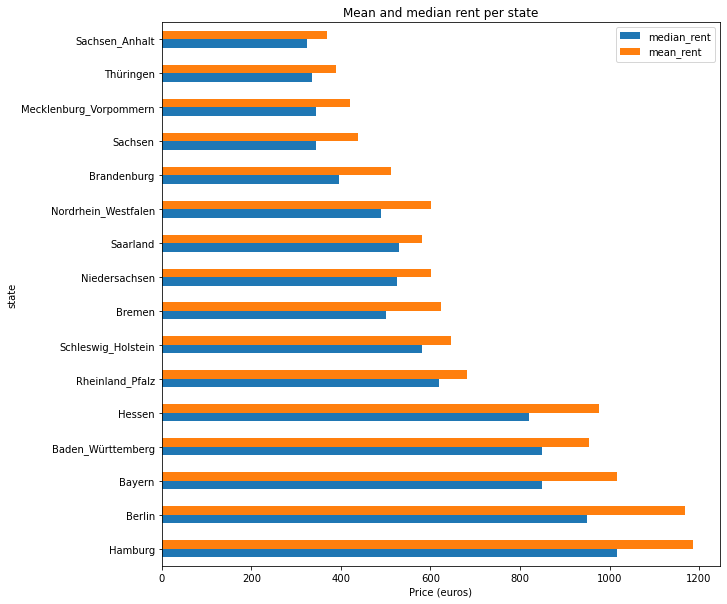

In [11]:
# Create bar plot showing mean and median rent for each state
avg_state_rent.reindex(index= avg_state_rent.mean(axis= 1).sort_values(ascending= False).index).plot(kind= 'barh', figsize= (10, 10))
plt.title('Mean and median rent per state')
plt.xlabel('Price (euros)');

- We note that location appears to have an impact on the mean and median prices of rent. Sachsen_Anhalt offers the lowest rent, while Hamburg offers the hightest rent. 

In [12]:
#Create dataframe with state and rent
state_rent = rentals_eda[['state', 'rent']]
state_rent.head()

,state,rent
0,Nordrhein_Westfalen,595.0
1,Rheinland_Pfalz,800.0
2,Sachsen,965.0
3,Sachsen,343.0
4,Bremen,765.0


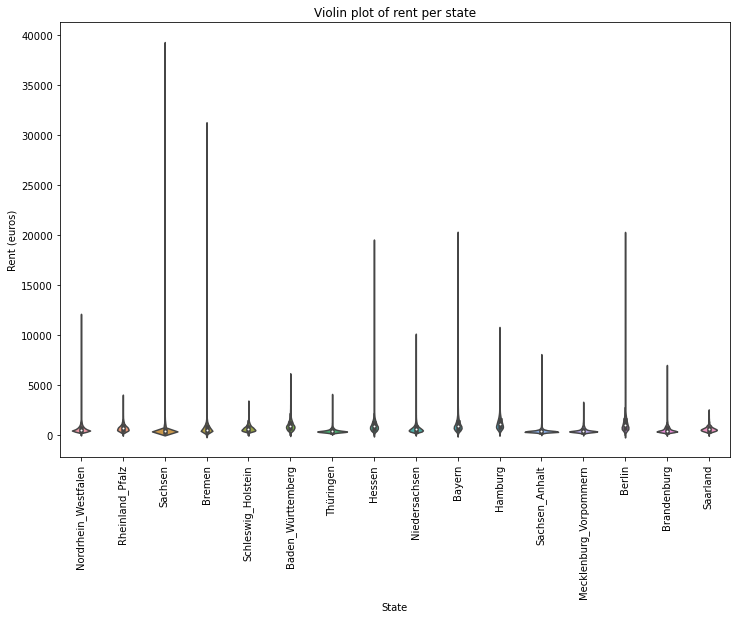

In [13]:
#Create violinplot that shows the range and distribution of rent per state
plt.subplots(figsize=(12, 8))
sns.violinplot(x= 'state', y= 'rent', data= state_rent)
plt.xticks(rotation='vertical')
plt.ylabel('Rent (euros)')
plt.xlabel('State')
plt.title('Violin plot of rent per state');

- We note that Sachsen appears to have the widest price range. 
- We also note prices are generally clustered around the median price for most of the states, except Berlin, Hamburg, Bayern, Hessen and Baden Wurttemberg that have a bit more variation in prices. 
- Lastly, we note that Sachsen Anhalt seems to have most of its prices located around its median, with less variation than other states. 

## 5.1.2 One-way ANOVA on state means 

- We will determine if the change in means from one state to another is as a result of natural variation.
- $H_{0}$: $μ_{1}$ = $μ_{2}$ = ... = $μ_{r}$
- $H_{1}$: two or more means are different from the others
- We will test the hypothesis at the p = 0.05 significant level

In [14]:
#Fit a linear regression model that explores the relationship between state and rent
model = ols('rent ~ state', data = state_rent).fit()
anova_table = sm.stats.anova_lm(model,  type = 2)
anova_table

,df,sum_sq,mean_sq,F,PR(>F)
state,15.0,1.549905e+10,1.033270e+09,4943.914383,0.0
Residual,266552.0,5.570894e+10,2.089984e+05,NaN,NaN


- Our F-statistic of 4944 suggests that the ratio of our mean square error between states and within states is quite large. We also note that that this leads to p value of practically zero.

- We therefore establish that location on a state-wide level strongly influences rent.

# 5.2 Relationship between quantity supplied and rent 

In [15]:
'''Create a dataframe that show the total number of listings, the total square meters of available space 
and mean and median rent for each state'''
state_supply = rentals_eda.groupby(['state']).agg(total_state_listings = pd.NamedAgg(column = 'rent', aggfunc = 'size'), \
                                               total_state_sqm = pd.NamedAgg(column = 'livingSpace', aggfunc = 'sum'), \
                                                 mean_rent = pd.NamedAgg(column = 'rent', aggfunc = 'mean'), \
                                                 median_rent = pd.NamedAgg(column = 'rent', aggfunc = 'median'))
state_supply

,total_state_listings,total_state_sqm,mean_rent,median_rent
state,,,,
Baden_Württemberg,16010,1344106.73,953.155464,850.000
Bayern,21541,1720648.67,1017.062728,850.000
Berlin,10281,842218.62,1168.231671,949.000
Brandenburg,6882,475000.09,511.034536,394.995
Bremen,2944,214511.47,623.775258,501.415
Hamburg,3732,312274.45,1186.915180,1015.500
Hessen,17698,1466867.13,976.305499,820.500
Mecklenburg_Vorpommern,6583,416641.77,420.453020,345.000
Niedersachsen,16460,1265306.89,600.107866,525.000


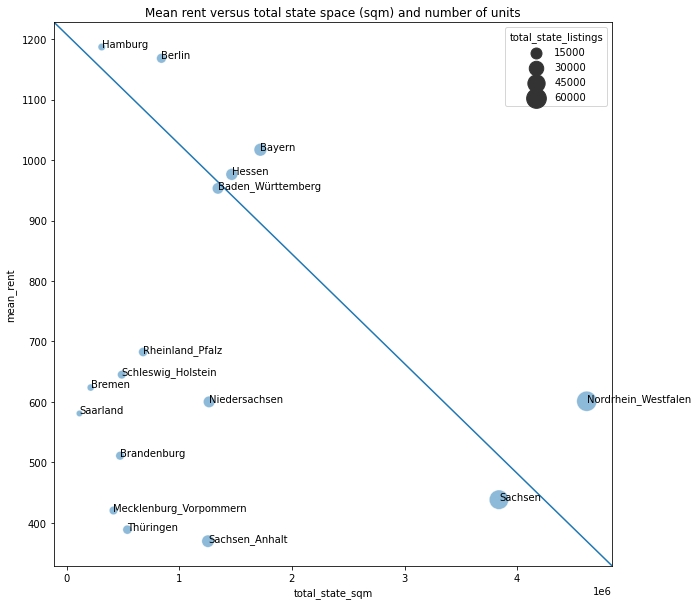

In [16]:
#Plat mean rent against the total number of listings and total square meters of space for each state
x = state_supply.total_state_sqm
y = state_supply.mean_rent
state = state_supply.index
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(x = 'total_state_sqm', y = 'mean_rent', data= state_supply, \
                size = 'total_state_listings', sizes=(40, 400), alpha = 0.5)
for s, x, y in zip(state, x, y):
    plt.annotate(s, (x, y))
plt.title('Mean rent versus total state space (sqm) and number of units')
ax.plot([1, 0], [0, 1], transform=ax.transAxes);

- We note a pattern emerging for three state clusters, where rent increases with limited supply in both the number of listings and space available. These clusters in order of higher rent and lower supply include:
    - Hamburg and Berlin (High rent, low supply)
    - Bayern, Hessen and Baden Wurttemberg (Moderate rent, moderate supply)
    - Sachsen and Nordhein Westfalen (Low rent, low supply)
- The remaining states form a cluster with no clear pattern in terms of the influence of supply on rent

# 5.3 Relationship between rent and other state-wise features

## 5.3.1 Creating dataframe for geo-economic data

In [17]:
geo_economy.head()

,state,area_km2,population_2019,population_per_km2,gdp_per_capita_2018,hdi
0,Baden-Württemberg,35752,11100394,310,47290,0.953
1,Bavaria(Bayern),70552,13124737,185,48323,0.947
2,Berlin,892,3669491,4086,41967,0.950
3,Brandenburg,29479,2521893,85,29541,0.914
4,Bremen,419,681202,1630,49215,0.951


- We note that the geo_economy dataframe and rentals_eda dataframe have different, but similar names for states.

In [18]:
#View the names of states from our geo_economy dataframe
stateNames_geo_economy = geo_economy.state
stateNames_geo_economy

0                               Baden-Württemberg
1                                 Bavaria(Bayern)
2                                          Berlin
3                                     Brandenburg
4                                          Bremen
5                                         Hamburg
6                                   Hesse(Hessen)
7                     Lower Saxony(Niedersachsen)
8                          Mecklenburg-Vorpommern
9     North Rhine-Westphalia(Nordrhein-Westfalen)
10          Rhineland-Palatinate(Rheinland-Pfalz)
11                                       Saarland
12                                Saxony(Sachsen)
13                  Saxony-Anhalt(Sachsen-Anhalt)
14                             Schleswig-Holstein
15                           Thuringia(Thüringen)
Name: state, dtype: object

In [19]:
#View the names of states from our rentals_eda dataframe
stateNames_rentals_eda = list(set(rentals_eda.state))
stateNames_rentals_eda

['Rheinland_Pfalz',
 'Baden_Württemberg',
 'Hamburg',
 'Sachsen',
 'Hessen',
 'Mecklenburg_Vorpommern',
 'Berlin',
 'Bayern',
 'Niedersachsen',
 'Saarland',
 'Thüringen',
 'Brandenburg',
 'Nordrhein_Westfalen',
 'Schleswig_Holstein',
 'Bremen',
 'Sachsen_Anhalt']

In [20]:
#Change state names from geo_economy dataframe to state names from rentals_eda
for geo_name in stateNames_geo_economy:
    for rentals_name in stateNames_rentals_eda:
        if fuzz.WRatio(geo_name, rentals_name) > 80:
            geo_economy.state = geo_economy.state.replace(geo_name, rentals_name)
            
geo_economy.state    

0          Baden_Württemberg
1                     Bayern
2                     Berlin
3                Brandenburg
4                     Bremen
5                    Hamburg
6                     Hessen
7                    Sachsen
8     Mecklenburg_Vorpommern
9        Nordrhein_Westfalen
10           Rheinland_Pfalz
11                  Saarland
12                   Sachsen
13                   Sachsen
14        Schleswig_Holstein
15                 Thüringen
Name: state, dtype: object

In [21]:
#Create dataframe that includes geo economic data and mean and median rents for each state
geo_economic = geo_economy.join(avg_state_rent, on= 'state', how = 'inner')
geo_economic

,state,area_km2,population_2019,population_per_km2,gdp_per_capita_2018,hdi,median_rent,mean_rent
0,Baden_Württemberg,35752,11100394,310,47290,0.953,850.000,953.155464
1,Bayern,70552,13124737,185,48323,0.947,850.000,1017.062728
2,Berlin,892,3669491,4086,41967,0.950,949.000,1168.231671
3,Brandenburg,29479,2521893,85,29541,0.914,394.995,511.034536
4,Bremen,419,681202,1630,49215,0.951,501.415,623.775258
5,Hamburg,755,1847253,2439,66879,0.975,1015.500,1186.915180
6,Hessen,21115,6288080,297,46923,0.949,820.500,976.305499
7,Sachsen,47609,7993448,168,38423,0.922,344.350,438.347298
12,Sachsen,18416,4077937,221,31453,0.930,344.350,438.347298
13,Sachsen,20446,2208321,108,28800,0.908,344.350,438.347298


## 5.3.2 Relationship between rent and total land mass, as well as other geo-economic information 

In [22]:
#Create function that takes generates a plot showing the influence of geo-economic information on rent
def geo_economic_plot(df, state_col, geo_economic_col, average_col):
    geo_econ = df[geo_economic_col]
    average = df[average_col]
    state = df[state_col]
    fig, ax = plt.subplots(figsize = (10,10))
    sns.scatterplot(x = geo_econ, y = average, data = df, legend = False, hue = state, alpha = 0.5)
    for s, x, y in zip(state, geo_econ, average):
        plt.annotate(s, (x, y))
    plt.title(f'{average_col} versus {geo_economic_col}')

### 5.3.2.1 Rent versus land mass

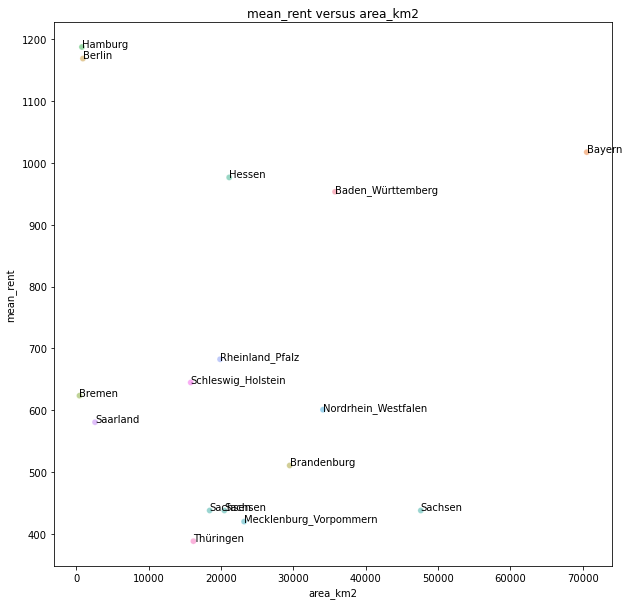

In [23]:
geo_economic_plot(geo_economic, 'state', 'area_km2', 'mean_rent')

- We note that Hamburg and Berlin form a unique cluster with low land mass and high rents. 
- Hess, Baden_Wurttenberg and Bayern also form a cluster with moderately high rent, although Bayern has a high rent in spite of a large land mass.
- The other states form a cluster where it is not clear that rent correlates with area. 

### 5.3.2.2 Rent versus population

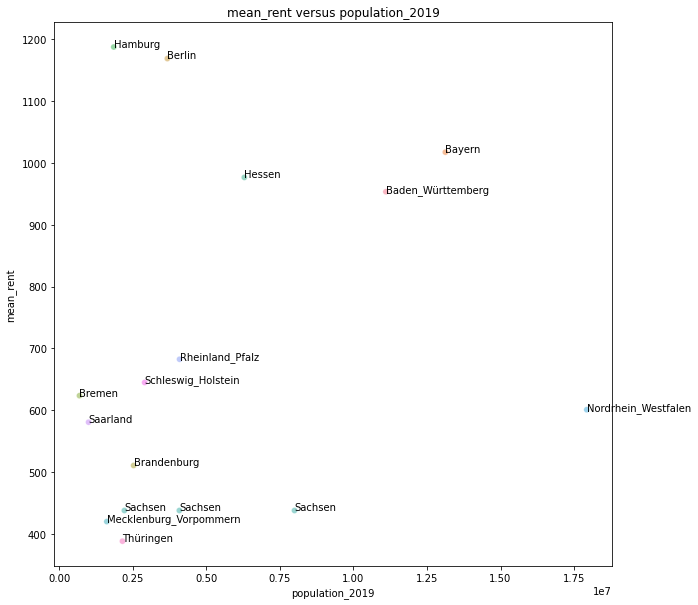

In [24]:
geo_economic_plot(geo_economic, 'state', 'population_2019', 'mean_rent')

- We note the same clusters for rent versus population as we did rent versus land mass and we note that Nordhein Westfalen has the highest population in germany.

### 5.3.2.2 Rent Versus gdp per capita

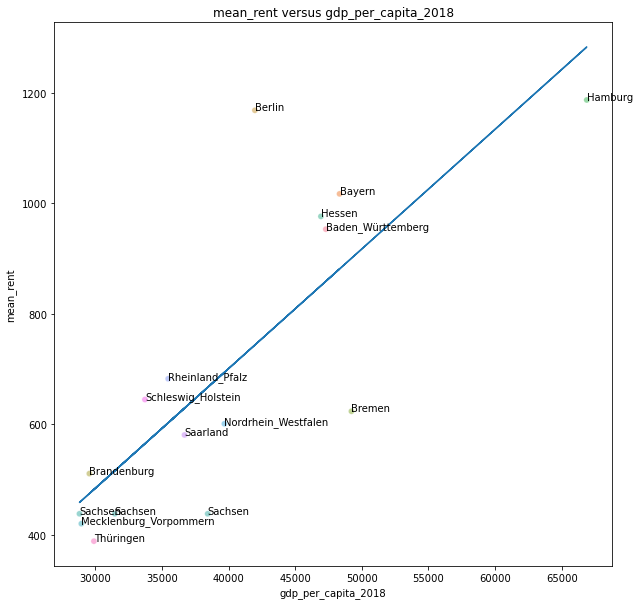

In [25]:
geo_economic_plot(geo_economic, 'state', 'gdp_per_capita_2018', 'mean_rent')
m, b = np.polyfit(geo_economic.gdp_per_capita_2018, geo_economic.mean_rent, 1)
plt.plot(geo_economic.gdp_per_capita_2018, m * geo_economic.gdp_per_capita_2018 + b);

- There seems to be a positive association of rent with gdp per capita. We also observe that Berlin has a comparable mean rent to Hamburg even though Hamburg has a higher gdp per capita. 

### 5.3.2.3 Rent versus hdi

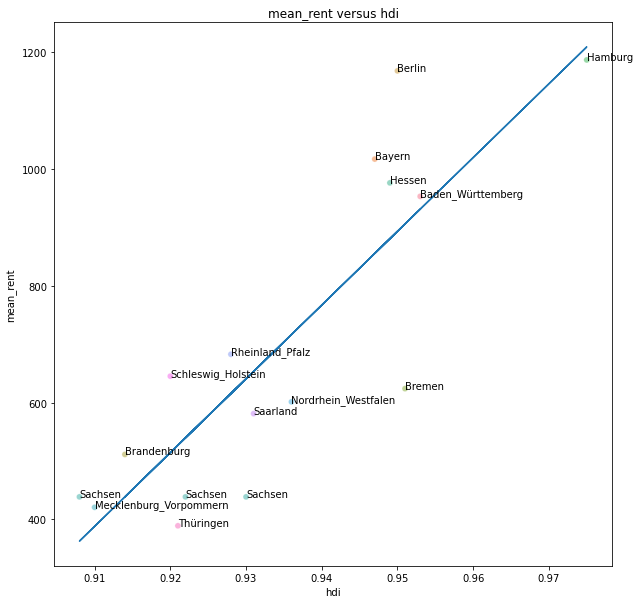

In [26]:
geo_economic_plot(geo_economic, 'state', 'hdi', 'mean_rent')
m, b = np.polyfit(geo_economic.hdi, geo_economic.mean_rent, 1)
plt.plot(geo_economic.hdi, m * geo_economic.hdi + b);

- We see the same trend of rent being positively correlated with hdi as gdp_per_capita.

## 5.4 Variation of rent with time

In [27]:
#Convert date column to datetime
rentals_eda.date = pd.to_datetime(rentals.date)
rentals_eda.date.dtype

dtype('<M8[ns]')

In [28]:
#Create dataframe with a datetime index
rentals_date = rentals_eda.set_index('date')
rentals_date.index

DatetimeIndex(['2019-05-01', '2019-05-01', '2019-10-01', '2019-05-01',
               '2020-02-01', '2020-02-01', '2020-02-01', '2020-02-01',
               '2020-02-01', '2019-10-01',
               ...
               '2018-09-01', '2019-05-01', '2019-10-01', '2018-09-01',
               '2020-02-01', '2020-02-01', '2019-05-01', '2020-02-01',
               '2019-05-01', '2020-02-01'],
              dtype='datetime64[ns]', name='date', length=266572, freq=None)

In [29]:
#Create dateframe of rent per state that is resampled by the year
resampled_df = rentals_date.groupby('state')[['rent']].resample('Y').mean()
resampled_df.head()

rent
state             date                   
Baden_Württemberg 2018-12-31   985.494495
                  2019-12-31   938.669842
                  2020-12-31   962.000339
Bayern            2018-12-31  1049.904901
                  2019-12-31  1006.151652

In [30]:
#Create dataframe with no index to enable plotting
resampled_plot = resampled_df.reset_index(level = [0, 1])
resampled_plot.head()

,state,date,rent
0,Baden_Württemberg,2018-12-31,985.494495
1,Baden_Württemberg,2019-12-31,938.669842
2,Baden_Württemberg,2020-12-31,962.000339
3,Bayern,2018-12-31,1049.904901
4,Bayern,2019-12-31,1006.151652


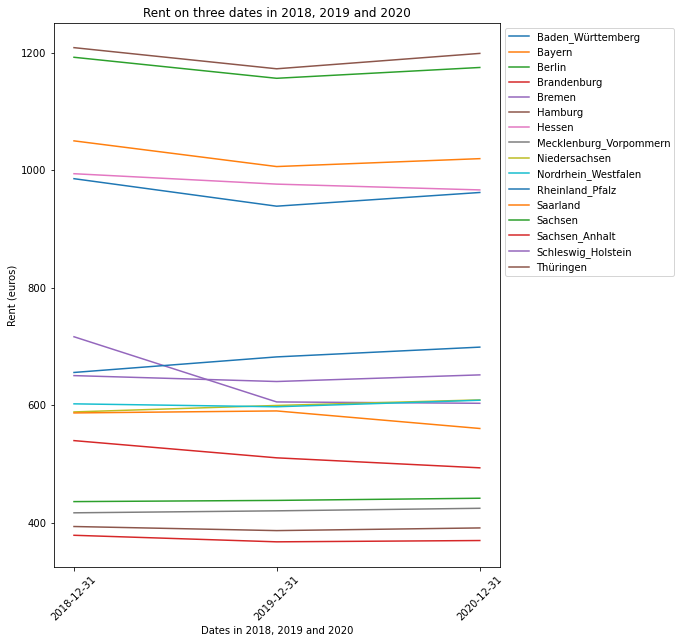

In [31]:
#Create plot of state mean rents for dates in 2018, 2019 and 2020
states = resampled_plot.state.unique()
dates = resampled_plot.date.unique()
fig, ax = plt.subplots(figsize = [8, 10])
for state in states:
    plt.plot(resampled_plot.loc[resampled_plot['state'] == state, ['date']], \
             resampled_plot.loc[resampled_plot['state'] == state, ['rent']])
plt.xticks(dates, rotation = 45)
plt.legend(states, loc="upper center", bbox_to_anchor=(1.2, 1))
plt.xlabel('Dates in 2018, 2019 and 2020')
plt.ylabel('Rent (euros)')
plt.title('Rent on three dates in 2018, 2019 and 2020')
plt.show()

- There is no general trend with rents increaseing or decreasing with time.
- For some states, rent actually decreases between 2018 and 2019 before rising again in 2020 (pre-covid)

## 5.5 Relationship between rent and advertized features 

In [32]:
#View columns
rentals_eda.columns

Index(['state', 'serviceCharge', 'heatingType', 'telekomTvOffer', 'newlyConst',
       'balcony', 'picturecount', 'pricetrend', 'telekomUploadSpeed',
       'totalRent', 'yearConstructed', 'scoutId', 'firingTypes', 'hasKitchen',
       'cellar', 'rent', 'livingSpace', 'condition', 'interiorQual',
       'petsAllowed', 'lift', 'typeOfFlat', 'zip_code', 'noRooms',
       'thermalChar', 'numberOfFloors', 'garden', 'district',
       'town_municipality', 'date'],
      dtype='object')

In [65]:
#Review the relationship between heating type and mean rent
rentals_eda.groupby('heatingType')[['rent']].mean().sort_values(by = 'rent')

,rent
heatingType,
night_storage_heater,460.241650
stove_heating,495.298700
electric_heating,546.924574
central_heating,588.598409
district_heating,598.502995
self_contained_central_heating,604.403661
oil_heating,658.304804
gas_heating,659.073608
wood_pellet_heating,869.830814


- floor_heating appears to yield highest rent
- Oil and gas heating have similar values for mean rent of 660 euros

In [34]:
##Review the relationship between telekomTvofer and mean rent
rentals_eda.groupby('telekomTvOffer')['rent'].mean()

telekomTvOffer
NONE             555.319399
ONE_YEAR_FREE    631.549718
ON_DEMAND        583.621414
Name: rent, dtype: float64

- Rent seems to be higher for units that include one year free tv

In [35]:
##Review the relationship between construction status and mean rent
rentals_eda.groupby('newlyConst')['rent'].mean()

newlyConst
False     610.283653
True     1097.095026
Name: rent, dtype: float64

- Rents seem to be higher for units in newly constructed buildings

In [36]:
#Review the relationship between the availability of a balcony and mean rent
rentals_eda.groupby('balcony')['rent'].mean()

balcony
False    493.947197
True     744.643942
Name: rent, dtype: float64

- Rent seems to be higher for those units with a balcony

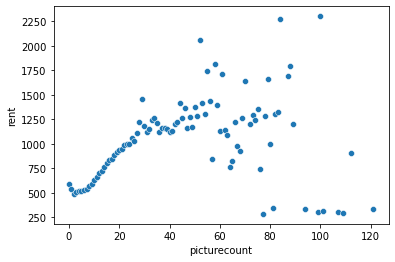

In [37]:
#Review the relationship between picturecount and mean rent
sns.scatterplot(x = 'picturecount', y = 'rent', data = rentals_eda.groupby('picturecount')[['rent']].mean());

- Rent seems to rise steadily with the number of pictures to about 25 pictures, afterwhich there is no clear association between the nuber of pictures and rent. It could be the case that more expensive units incite more pictures, but only up to a point.

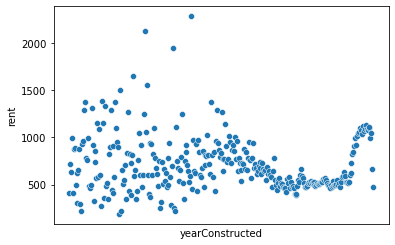

In [38]:
#Review the relationship between year constructed and mean rent
fig, axes = plt.subplots(figsize = (6,4))
sns.scatterplot(x = 'yearConstructed', y = 'rent', data = rentals_eda.groupby('yearConstructed')[['rent']].mean())
axes.set(xticks=[]);

- There is no clear association between year constructed an rent. This is counter intuitive because one would expect new units to fetch higher rent. 

In [39]:
#Review the relationship between firing types and mean rent
rentals_eda.groupby('firingTypes')[['rent']].mean().sort_values(by = 'rent', ascending = False)

,rent
firingTypes,
hydro_energy,1306.326923
combined_heat_and_power_renewable_energy,1154.591061
bio_energy,1126.397407
combined_heat_and_power_regenerative_energy,1092.786979
environmental_thermal_energy,1035.924492
geothermal,1027.109219
combined_heat_and_power_fossil_fuels,988.426394
solar_heating,979.510510
wind_energy,975.000000


- We note that heavy natural gas and coal fired units have lower rents compared to units that use renewable energy sources (i.e. hydro_energy, combined_heat_and_power_renewable_energy, bio_energy, etc.)

In [50]:
#Review the relationship between the availability of a kitchen and mean rent
rentals_eda.groupby('hasKitchen')[['rent']].describe()

rent                                                      \
               count        mean         std  min    25%     50%     75%   
hasKitchen                                                                 
False       175061.0  551.653499  411.175290  0.0  315.0  423.22   660.0   
True         91507.0  834.172306  634.288617  0.0  434.0  684.00  1045.0   

                     
                max  
hasKitchen           
False       39200.0  
True        20000.0

- Units with a kitchen seem to fetch higher rents.

In [49]:
rentals_eda.groupby('cellar')[['rent']].describe()

rent                                                           
           count        mean         std  min    25%    50%    75%      max
cellar                                                                     
False    95684.0  636.458251  510.202326  0.0  335.0  490.0  790.0  39200.0
True    170884.0  655.454854  520.406048  0.0  340.0  495.0  800.0  30990.0

- There is no clear advantage to having a cellar in terms on its effect on rent.

In [42]:
#Review the relationship between the condition of the unit and mean rent
rentals_eda.groupby('condition')[['rent']].mean().sort_values(by = 'rent', ascending = False)

,rent
condition,
first_time_use,1090.501416
mint_condition,974.578202
first_time_use_after_refurbishment,780.803332
fully_renovated,584.153071
modernized,575.439567
well_kept,547.061781
refurbished,494.913952
negotiable,484.453280


- First time use rental units appear to fetch the highest rents

In [43]:
#Review the relationship between interior quality of the apartment and mean rent
rentals_eda.groupby('interiorQual')[['rent']].mean().sort_values(by = 'rent', ascending = False)

,rent
interiorQual,
luxury,1591.707512
sophisticated,884.834406
normal,466.456260
simple,421.374234


- Luxury and sophisticated units appear to fetch higher rents

In [44]:
#Review the relationship between whether pets are allowed and mean rent
rentals_eda.groupby('petsAllowed')[['rent']].mean().sort_values(by = 'rent', ascending = False)

,rent
petsAllowed,
no,741.876075
yes,620.879140
negotiable,607.611719


- Units that don't allow pets seem to be more expensive than those who allow pets

In [45]:
#Review the relationship between whether the apartment has a lift and mean rent
rentals_eda.groupby('lift')[['rent']].mean().sort_values(by = 'rent', ascending = False)

,rent
lift,
True,921.565405
False,564.443866


- Units that have a lift seem to be more expensive than those without

In [46]:
#Review the relationship between the type of flat and mean rent
rentals_eda.groupby('typeOfFlat')[['rent']].mean().sort_values(by = 'rent', ascending = False)

,rent
typeOfFlat,
penthouse,1557.827817
loft,1214.778183
maisonette,1057.470618
terraced_flat,963.055989
apartment,625.873343
ground_floor,618.787640
other,617.429205
roof_storey,607.154940
raised_ground_floor,604.089383


- penthouse's, loft's and maisonette's seem to fetch higher rents than other rental unit styles

In [47]:
#Top zip codes for mean rent
rentals_eda.groupby('zip_code')[['rent', 'state', 'district', 'town_municipality']]. \
                    agg({'rent': 'mean', 'state': 'max', 'district' : 'max', 'town_municipality': 'max'}).sort_values(by = 'rent', ascending = False).head(10)

,rent,state,district,town_municipality
zip_code,,,,
80539,4752.773846,Bayern,München,Schwabing
89538,4240.000000,Bayern,München,Lehel
10577,3950.000000,Berlin,Berlin,Tiergarten_Tiergarten
8382,3900.000000,Baden_Württemberg,Bodenseekreis,Kressbronn_am_Bodensee
14053,3200.000000,Berlin,Berlin,Charlottenburg_Charlottenburg
80538,3113.080000,Bayern,München,Maxvorstadt
81679,3031.366000,Bayern,München,Haidhausen
91747,3000.000000,Bayern,Weißenburg_Gunzenhausen,Westheim
22148,2900.000000,Hamburg,Hamburg,Rotherbaum


- We note that the zip codes with the highest rent seem to be in Bayern in spite of observing the highest mean rents in Hamburg and Berlin

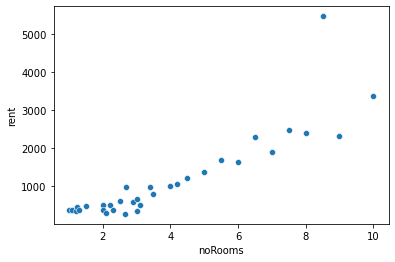

In [48]:
#Review the relationship between the number of rooms and mean rent
sns.scatterplot(x = 'noRooms', y = 'rent', data = rentals_eda.groupby('noRooms')[['rent']].mean());

 - As the number of rooms increase the rent seems to increase

# 6. Summary 

- There are appears to be three groups of states that have similar their rent behavior. These include the high-rent states of Berlin and Hamburg, the moderate-rent states of Hessen, Bayern and Baden Wurttenberg, and the low-rent states consisting of the remaining 10 states. 
- Location is a considerable determinant of rent
- We examined features on a state-wide level and established that rent is affected by macro-economic conditions such as the total supply of rental units, population, regional gdp and the human development index.
- There was no clear trend associated to price movements of rent over the three dates when data was accumulated.
- The presence of certain features seemed to correlate with higher rent.